# Exploratory Data Analysis (EDA)

In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

# load datasets
applications = pd.read_csv("../data/processed/cleaned_applications.csv") 
credit_records = pd.read_csv("../data/processed/cleaned_credit_records.csv")

### Distribution of Numeric Features

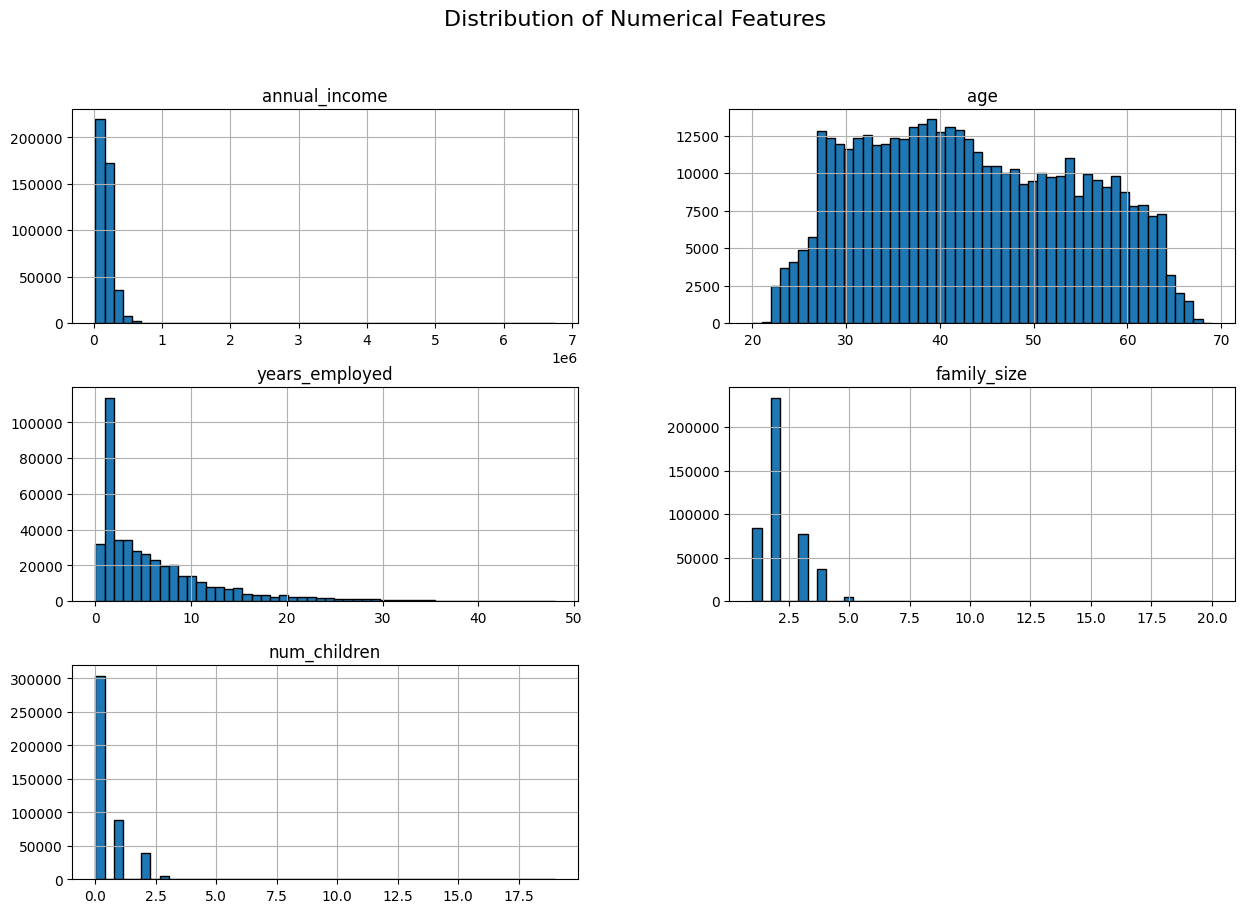

In [175]:
numeric_cols = ['annual_income', 'age', 'years_employed', 'family_size', 'num_children']
binary_cols = ['work_phone', 'phone', 'email']
cat_cols = ['gender', 'own_car', 'own_realty', 'income_type', 'education_type',
            'family_status', 'housing_type', 'occupation']

applications[numeric_cols].hist(figsize = (15, 10), bins = 50, edgecolor = 'black')
plt.suptitle("Distribution of Numerical Features", fontsize=16)
plt.show()

- `annual_income` is highly right-skewed. hence, we may apply log-transformation to reduce skewness.
- `years_employed` is highly right skewed. hence, we may apply log-transformation to reduce skewness.
- `family_size` has values mostly in the 1-4 range, but it contains some outliers. hence, we cap the values above a reasonable maximum, 8.
- `num_children` has values mostly in the 0-2 range, but it contains some outliers. hence, we cap the values above a reasonable maximum, 6.

In [176]:
applications['log_annual_income'] = np.log1p(applications['annual_income'])
applications['log_years_employed'] = np.log1p(applications['years_employed'])
applications['family_size'] = applications['family_size'].clip(upper=8)
applications['num_children'] = applications['num_children'].clip(upper=6)


### Correlation between Numeric Features

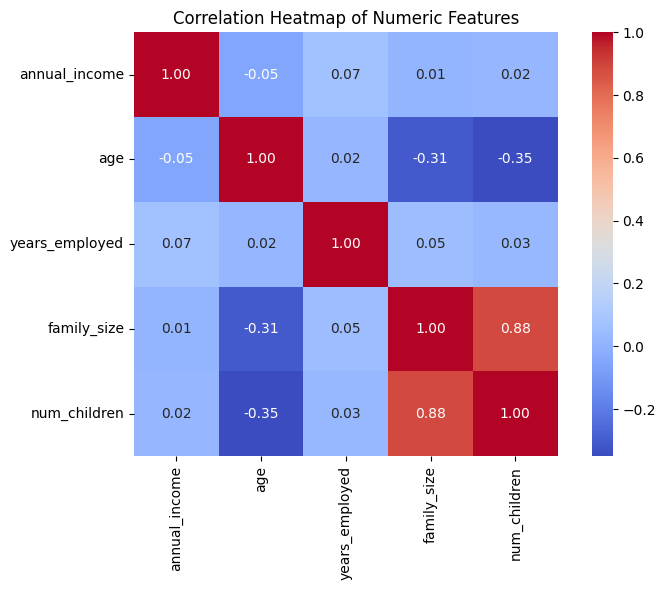

In [177]:
# Compute correlation matrix
corr_matrix = applications[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()

- `num_children` and `family_size` have high correlation (0.88). hence, we only retain one of them to reduce dimensionalaity. we remove `num_children`, as it is implied in `family_size`

In [178]:
applications = applications.drop('num_children', axis=1)

### Distribution of Binary Features

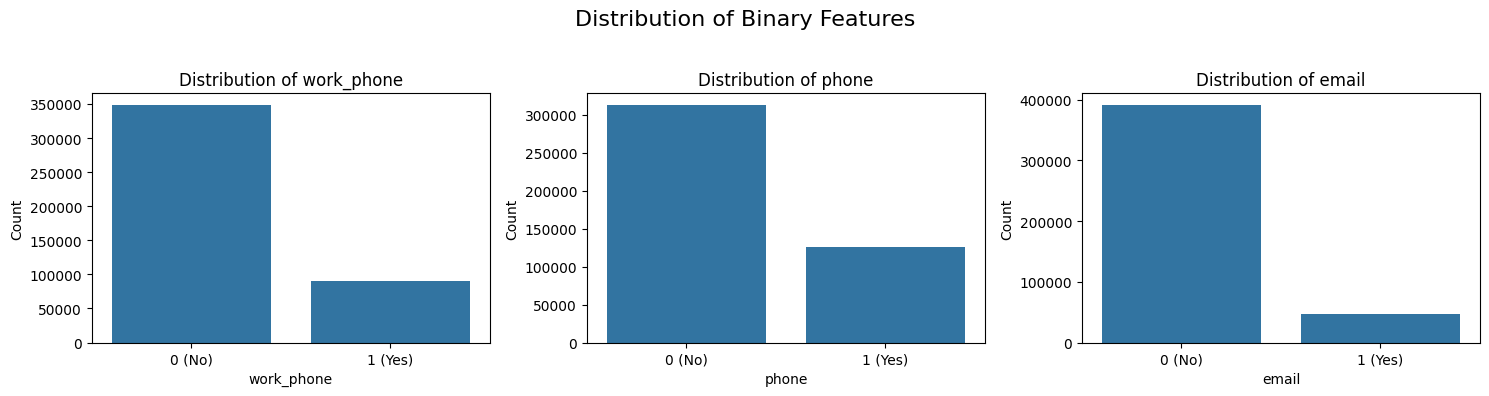

In [179]:
fig, axes = plt.subplots(1, len(binary_cols), figsize=(5 * len(binary_cols), 4))

# If there's only one column, wrap axes in list
if len(binary_cols) == 1:
    axes = [axes]

# Plot bar charts
for i, col in enumerate(binary_cols):
    sns.countplot(data=applications, x=col, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['0 (No)', '1 (Yes)'])

plt.suptitle("Distribution of Binary Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Distribution of Categorical Features

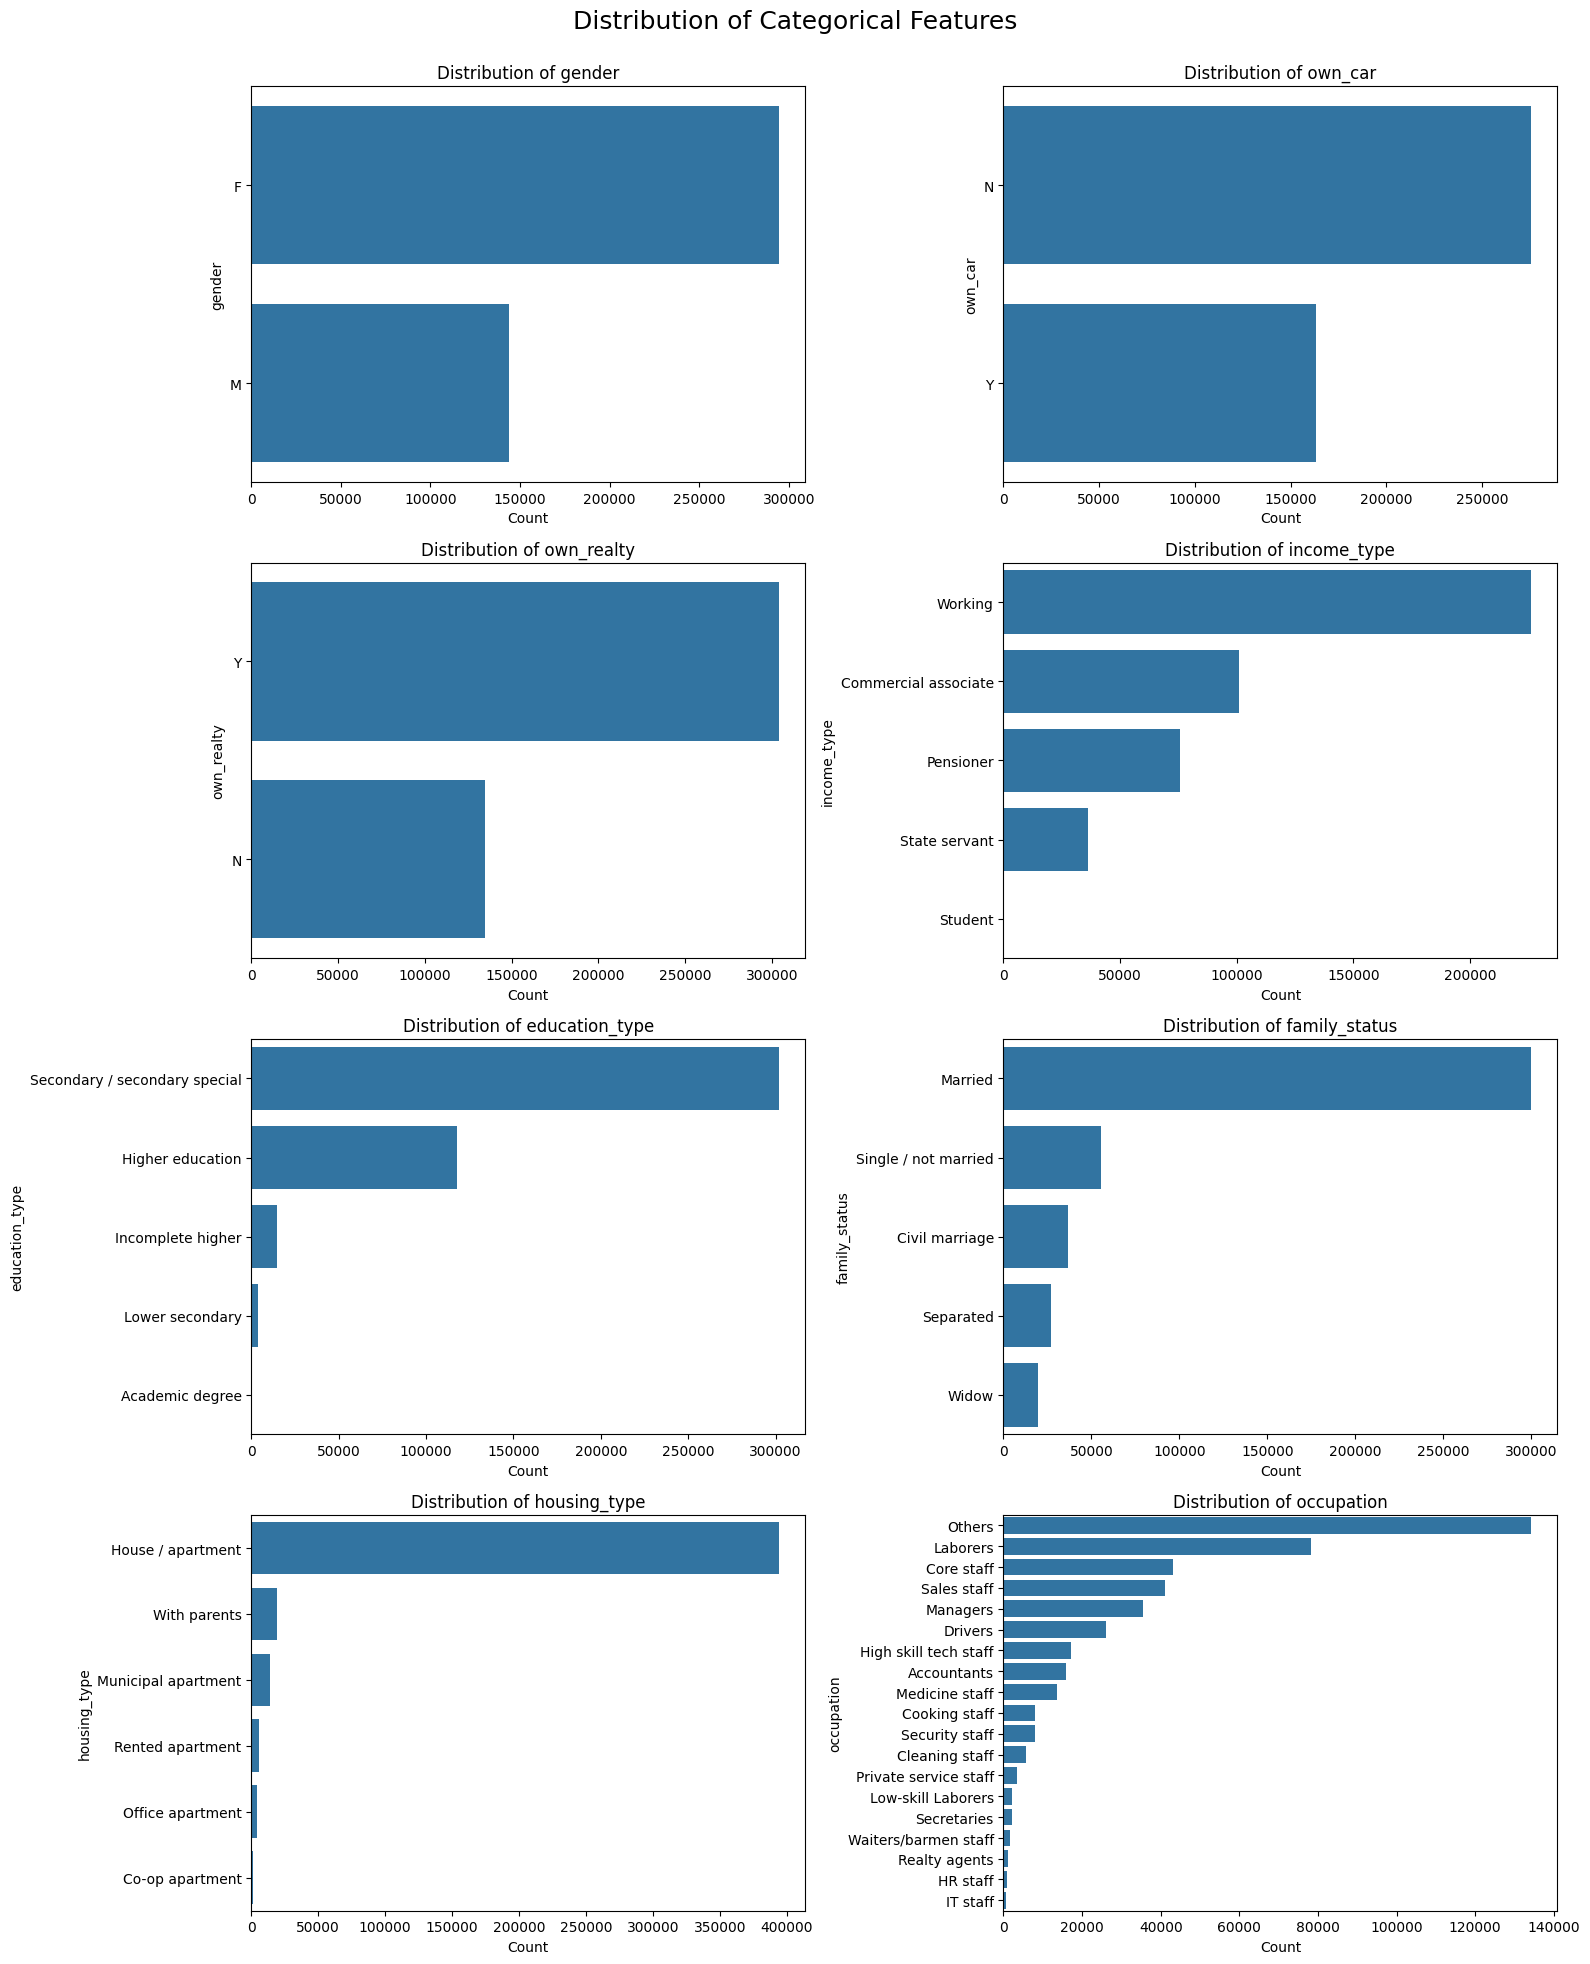

In [180]:
# Fixed grid size
n_cols = 2
n_rows = 4  # since we have 8 features

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 20))
axes = axes.flatten()

# Generate countplots
for i, col in enumerate(cat_cols):
    sns.countplot(data=applications, y=col, order=applications[col].value_counts().index, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel("Count")
    axes[i].set_ylabel(col)

# Layout cleanup
plt.tight_layout(rect=[0, 0, 1, 0.96])
fig.suptitle("Distribution of Categorical Features", fontsize=18)

plt.show()

### One-hot Encoding

In [181]:
# binary columns
applications['own_car'] = applications['own_car'].replace({"Y":1, "N":0}).astype(int)
applications['own_realty'] = applications['own_realty'].replace({"Y":1, "N":0}).astype(int)
applications['gender'] = applications['gender'].replace({"M":1, "F":0}).astype(int)

C:\Users\ashle\AppData\Local\Temp\ipykernel_16376\3647355089.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  applications['own_car'] = applications['own_car'].replace({"Y":1, "N":0}).astype(int)
C:\Users\ashle\AppData\Local\Temp\ipykernel_16376\3647355089.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  applications['own_realty'] = applications['own_realty'].replace({"Y":1, "N":0}).astype(int)
C:\Users\ashle\AppData\Local\Temp\ipykernel_16376\3647355089.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated an

### Target Encoding

In [182]:
# multi-class columns
applications = pd.get_dummies(applications, columns=["income_type", "education_type", "family_status", "housing_type", "occupation"], drop_first=True)

### Scaling Continuous Features


In [183]:
continuous_features = ['log_annual_income', 'age', 'log_years_employed']

# Scale values between 0 and 1
scaler = MinMaxScaler()
applications[continuous_features] = scaler.fit_transform(applications[continuous_features])

## Flatten the status dataset
In `cleaned_credit_records.csv`, we convert the `status` variable to numeric values.

In [168]:
# assign a numerical severity level to late payments
status_mapping = {
    "0": 1, # on time
    "1": 2, # 1 month late
    "2": 3, # 2 months late
    "3": 4, 
    "4": 5,  
    "5": 6, # 5+ months late
}

credit_records["status_numeric"] = credit_records["status"].map(status_mapping)


# for each user, 
# - count how many months they paid off loans (C)
# - count how many months they had no loans (X)
# - sum the severity of all late months (status_numeric)

def sum_of_status(record):
    total_paid = (record['status'] == 'C').sum() 
    total_no_loans = (record['status'] == 'X').sum()
    sum_months_late = record['status_numeric'].dropna().sum()

    return pd.Series({
        'total_paid': total_paid,
        'total_no_loans': total_no_loans,
        'sum_months_late': sum_months_late #sum late payment months
    })

user_status_summary = credit_records.groupby("id").apply(sum_of_status).reset_index()
user_status_summary.head()

C:\Users\ashle\AppData\Local\Temp\ipykernel_16376\4293334640.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_status_summary = credit_records.groupby("id").apply(sum_of_status).reset_index()


,id,total_paid,total_no_loans,sum_months_late
0,5001711,0.0,1.0,3.0
1,5001712,9.0,0.0,10.0
2,5001713,0.0,22.0,0.0
3,5001714,0.0,15.0,0.0
4,5001715,0.0,60.0,0.0


# Merge the datasets

In [169]:
merged_df = applications.merge(user_status_summary, on="id", how="inner")
merged_df

,id,gender,own_car,own_realty,annual_income,work_phone,phone,email,family_size,age,...,occupation_Others,occupation_Private service staff,occupation_Realty agents,occupation_Sales staff,occupation_Secretaries,occupation_Security staff,occupation_Waiters/barmen staff,total_paid,total_no_loans,sum_months_late
0,5008804,1,1,1,427500.0,1,0,0,2.0,0.244898,...,True,False,False,False,False,False,False,13.0,1.0,3.0
1,5008805,1,1,1,427500.0,1,0,0,2.0,0.244898,...,True,False,False,False,False,False,False,12.0,1.0,3.0
2,5008806,1,1,1,112500.0,0,0,0,2.0,0.775510,...,False,False,False,False,False,True,False,7.0,16.0,7.0
3,5008808,0,0,1,270000.0,0,1,1,1.0,0.653061,...,False,False,False,True,False,False,False,0.0,3.0,2.0
4,5008809,0,0,1,270000.0,0,1,1,1.0,0.653061,...,False,False,False,True,False,False,False,0.0,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,1,1,1,315000.0,0,0,0,2.0,0.551020,...,False,False,False,False,False,False,False,0.0,8.0,23.0
36453,5149834,0,0,1,157500.0,0,1,1,2.0,0.265306,...,False,False,False,False,False,False,False,5.0,0.0,72.0
36454,5149838,0,0,1,157500.0,0,1,1,2.0,0.265306,...,False,False,False,False,False,False,False,14.0,0.0,72.0
36455,5150049,0,0,1,283500.0,0,0,0,2.0,0.591837,...,False,False,False,True,False,False,False,0.0,0.0,13.0


## Response Variable Labelling: KMeans Clustering

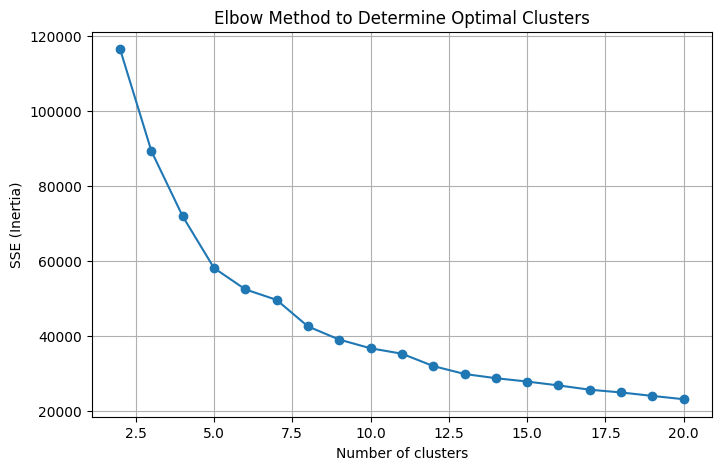

In [170]:
# Select features for clustering
kmeans_features = merged_df[["annual_income", "total_paid", "total_no_loans", "sum_months_late"]]

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(kmeans_features)

# Find optimal number of clusters using the Elbow Method
error = []
for i in range(2, 21):  # trying 2 to 20 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, random_state=42)
    kmeans.fit(scaled_features)
    error.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(2, 21), error, marker='o')
plt.title('Elbow Method to Determine Optimal Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('SSE (Inertia)')
plt.grid(True)
plt.show()

In [171]:
# Apply KMeans with k = 8
optimal_k = 8
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=300, random_state=42)
merged_df['cluster'] = kmeans.fit_predict(scaled_features)

# Inspect cluster behavior
cluster_summary = merged_df.groupby('cluster')[["annual_income", "total_paid", "total_no_loans", "sum_months_late"]].mean()
print(cluster_summary)


         annual_income  total_paid  total_no_loans  sum_months_late
cluster                                                            
0        128133.949851    3.559284        1.384016         6.658054
1        563421.292228    6.541969        3.538860         9.870466
2        177935.680195    1.861111       18.346320         4.153680
3        181820.613451    3.758014        2.058454        29.964488
4        172110.705582   31.845140        1.000425         7.614197
5        187630.434783    3.217391        4.043478       196.739130
6        263056.254632    4.183563        1.582716         7.128242
7        192212.736661    0.651463       40.448365         1.668675


Banks are less likely to approve credit card approvals for customers who have:
- a high number of late payments (`sum_months_late`)
- a low number of timely payments (`total_paid`)
- lower incomes (`annual_income`)

Therefore, clusters 3 and 5 may contain individuals who are more likely to default, or have poor credit behaviour.


In [172]:
merged_df['credit_status'] = merged_df['cluster'].apply(lambda x: "Bad" if x in [3, 5] else "Good")
merged_df = merged_df.drop(columns=["cluster", "sum_months_late", "total_paid", "total_no_loans"])
merged_df


,id,gender,own_car,own_realty,annual_income,work_phone,phone,email,family_size,age,...,occupation_Managers,occupation_Medicine staff,occupation_Others,occupation_Private service staff,occupation_Realty agents,occupation_Sales staff,occupation_Secretaries,occupation_Security staff,occupation_Waiters/barmen staff,credit_status
0,5008804,1,1,1,427500.0,1,0,0,2.0,0.244898,...,False,False,True,False,False,False,False,False,False,Good
1,5008805,1,1,1,427500.0,1,0,0,2.0,0.244898,...,False,False,True,False,False,False,False,False,False,Good
2,5008806,1,1,1,112500.0,0,0,0,2.0,0.775510,...,False,False,False,False,False,False,False,True,False,Good
3,5008808,0,0,1,270000.0,0,1,1,1.0,0.653061,...,False,False,False,False,False,True,False,False,False,Good
4,5008809,0,0,1,270000.0,0,1,1,1.0,0.653061,...,False,False,False,False,False,True,False,False,False,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,1,1,1,315000.0,0,0,0,2.0,0.551020,...,True,False,False,False,False,False,False,False,False,Bad
36453,5149834,0,0,1,157500.0,0,1,1,2.0,0.265306,...,False,True,False,False,False,False,False,False,False,Bad
36454,5149838,0,0,1,157500.0,0,1,1,2.0,0.265306,...,False,True,False,False,False,False,False,False,False,Bad
36455,5150049,0,0,1,283500.0,0,0,0,2.0,0.591837,...,False,False,False,False,False,True,False,False,False,Good


### Distribution of Response Variable (credit_status) 

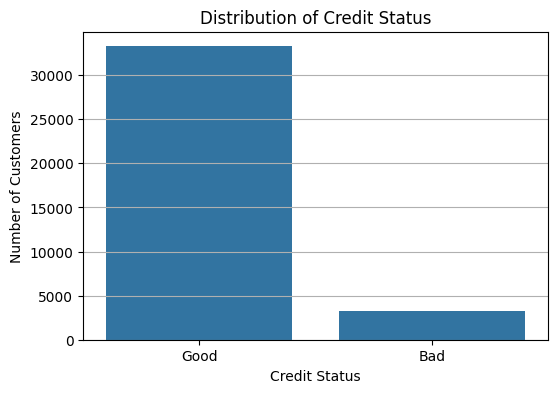

In [173]:
status_counts = merged_df['credit_status'].value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=status_counts.index, y=status_counts.values)
plt.title("Distribution of Credit Status")
plt.ylabel("Number of Customers")
plt.xlabel("Credit Status")
plt.grid(axis='y')
plt.show()


From the figure above, there is a class imbalance in the response variable. Therefore, we apply SMOTE to address the imbalance.

### SMOTE

In [ ]:
# Split into train and test sets
train_df, test_df = train_test_split(merged_df, test_size=0.2, random_state=42, stratify=merged_df["credit_status"])
# Save the test set
test_path = "../data/processed/ftest_set.csv"
test_df.to_csv(test_path, index=False)


In [184]:
# Split features and label
x = merged_df.drop(columns=["id", "credit_status"])
y = merged_df["credit_status"]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y #20% for testing
)

smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)


print(Counter(y_train_resampled))


train_resampled_df = pd.concat(
    [pd.DataFrame(x_train_resampled, columns=x_train.columns),
     pd.Series(y_train_resampled, name='credit_label')],
    axis=1)

train_resampled_df

Counter({'Good': 26601, 'Bad': 26601})


,gender,own_car,own_realty,annual_income,work_phone,phone,email,family_size,age,years_employed,...,occupation_Managers,occupation_Medicine staff,occupation_Others,occupation_Private service staff,occupation_Realty agents,occupation_Sales staff,occupation_Secretaries,occupation_Security staff,occupation_Waiters/barmen staff,credit_label
0,0,0,0,67500.0,0,1,0,3.0,0.204082,1.000000,...,False,False,False,False,False,True,False,False,False,Good
1,0,0,1,675000.0,0,1,0,3.0,0.469388,3.800000,...,False,False,False,False,False,True,False,False,False,Good
2,0,0,0,180000.0,0,0,0,2.0,0.571429,29.500000,...,False,True,False,False,False,False,False,False,False,Good
3,0,1,0,387000.0,0,0,0,3.0,0.326531,7.100000,...,True,False,False,False,False,False,False,False,False,Good
4,0,1,0,337500.0,1,0,1,1.0,0.122449,0.800000,...,False,False,True,False,False,False,False,False,False,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53197,0,0,0,157500.0,0,0,0,2.0,0.551020,8.400000,...,False,False,False,False,False,False,False,False,False,Bad
53198,0,1,0,157500.0,0,1,0,2.0,0.516514,7.792755,...,False,False,True,False,False,False,False,False,False,Bad
53199,0,0,0,112500.0,0,0,0,2.0,0.605136,15.485393,...,False,False,False,False,False,False,False,False,False,Bad
53200,0,0,1,175500.0,0,1,0,2.0,0.897959,1.000000,...,False,False,True,False,False,False,False,False,False,Bad


In [ ]:
merged_df.to_csv("../data/processed/final_data.csv", index=False)